In [1]:
import csv

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

# Model building

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = tf.keras.models.Sequential([
    # Reshape the input to simulate an "image-like" structure
    tf.keras.layers.Input((21 * 2,)),
    tf.keras.layers.Reshape((21, 2, 1)),  # Reshape to a 2D "image" with 1 channel
    
    # First Conv and Pooling block
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),  # Compatible pooling size for (21, 2)
    Dropout(0.2),

    # Second Conv and Pooling block
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),  # Again, compatible size for the reduced dimension
    Dropout(0.2),
    
    # Third Conv and Pooling block
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Dropout(0.2),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Model summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 21, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 2, 128)     │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 2, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,570 (564.73 KB)

 Trainable params: 144,570 (564.73 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 21, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 2, 128)     │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 2, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,570 (564.73 KB)

 Trainable params: 144,570 (564.73 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
training = model.fit(
    X_train_split,
    y_train_split, 
    epochs=1000,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
258/262 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1913 - loss: 2.6373
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1939 - loss: 2.6265 - val_accuracy: 0.6406 - val_loss: 1.0651
Epoch 2/1000
257/262 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5814 - loss: 1.1670
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5823 - loss: 1.1647 - val_accuracy: 0.7606 - val_loss: 0.6481
Epoch 3/1000
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7044 - loss: 0.8201
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7045 - loss: 0.8197 - val_accuracy: 0.8198 - val_loss: 0.5097
Epoch 4/1000
257/262 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7581 - loss: 0.6523
Epoch 4: saving model to model/keypoint_classifier/keypoint_clas

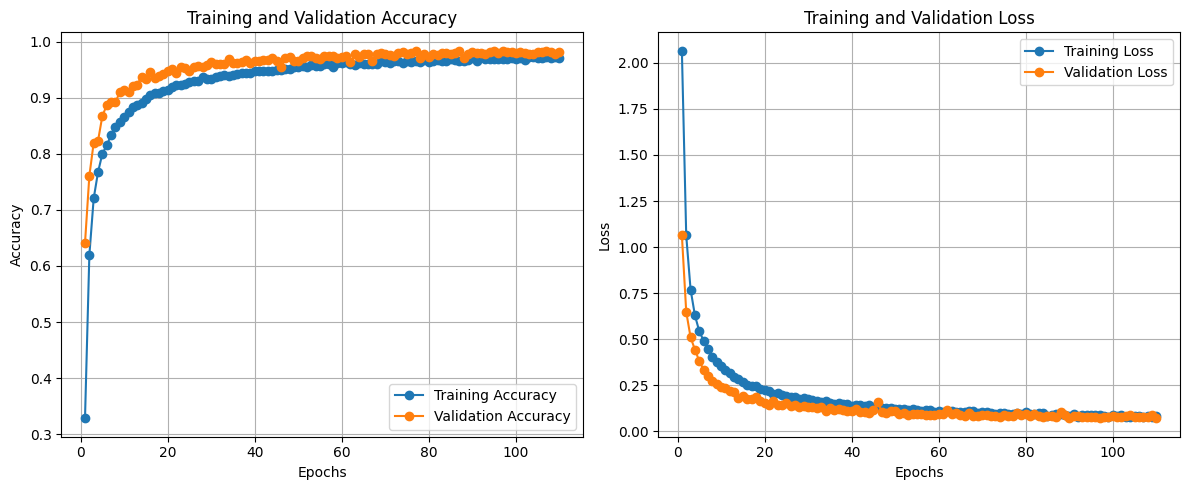

In [12]:
import matplotlib.pyplot as plt

# Assuming `history` is the returned object from `model.fit`
history_dict = training.history

# Extracting metrics
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - loss: 0.0581


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[9.61839719e-10 1.46446133e-09 6.46630156e-13 4.00661104e-09
 1.39181455e-14 9.57185262e-15 3.53504769e-12 3.11821298e-11
 2.23781514e-14 1.58596580e-09 1.11675747e-11 7.99192136e-12
 9.99999404e-01 6.17548778e-07 1.69906411e-09 4.34101782e-11
 9.21791601e-11 1.05354423e-11 5.78303239e-11 3.66177488e-12
 8.67620266e-13 1.30641192e-10 5.64160394e-12 1.23172948e-15
 2.15001226e-08 7.51444827e-12]
12


# Confusion matrix

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


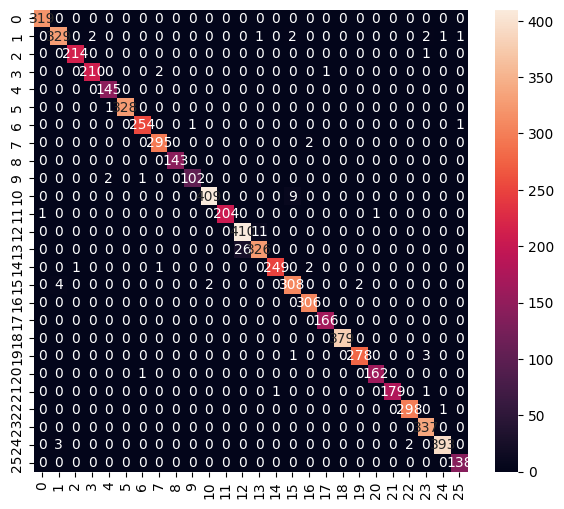

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       0.98      0.97      0.98       338
           2       1.00      1.00      1.00       215
           3       0.99      0.99      0.99       213
           4       0.98      1.00      0.99       145
           5       1.00      1.00      1.00       329
           6       0.99      0.99      0.99       256
           7       0.99      0.99      0.99       297
           8       1.00      1.00      1.00       143
           9       0.99      0.97      0.98       105
          10       1.00      0.98      0.99       418
          11       1.00      0.99      1.00       206
          12       0.94      0.97      0.96       421
          13       0.96      0.93      0.94       352
          14       1.00      0.98      0.99       253
          15       0.96      0.97      0.97       316
          16       0.99      1.00      0.99       306
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\IdeaPad\AppData\Local\Temp\tmpc8bs5gzd\assets


INFO:tensorflow:Assets written to: C:\Users\IdeaPad\AppData\Local\Temp\tmpc8bs5gzd\assets


Saved artifact at 'C:\Users\IdeaPad\AppData\Local\Temp\tmpc8bs5gzd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2096467423504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467424272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467424464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467421968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467426960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467426192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467421776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467425808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096467427152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2096669754576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  209666975476

156496

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.89934737e-10 1.49306600e-09 6.37222154e-13 4.15868140e-09
 1.54242108e-14 9.38864871e-15 3.39420549e-12 3.19686881e-11
 2.27548456e-14 1.69223657e-09 1.06117155e-11 8.30590804e-12
 9.99999404e-01 5.82890095e-07 1.71322301e-09 4.66273305e-11
 1.01175866e-10 1.06249809e-11 5.68941214e-11 3.51385869e-12
 9.00957911e-13 1.30697259e-10 5.04299944e-12 1.16483092e-15
 2.13361435e-08 8.46265419e-12]
12
